In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms


In [15]:
dataset = load_dataset("Xenova/quickdraw-small")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0,), (1,))  
])

def preprocess_ops(examples):
    examples['image'] = [preprocess(image) for image in examples['image']]
    return examples

dataset.set_transform(preprocess_ops)

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4500000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
})

In [17]:
n_samples = 100_000
train_dataset, test_dataset, val_dataset = dataset['train'], dataset['test'], dataset['valid']
train_dataset = train_dataset.shard(num_shards=10, index=0)
# test_dataset = test_dataset.shard(num_shards=10, index=0)
# train_dataset = train_dataset.shard(num_shards=10, index=0)
names = train_dataset.features['label'].names
n_classes = len(names)

In [21]:
import json

with open('labels.json', 'w') as f:
    json.dump(names, f)

In [12]:
def id_to_class(idx):
    return names[idx]

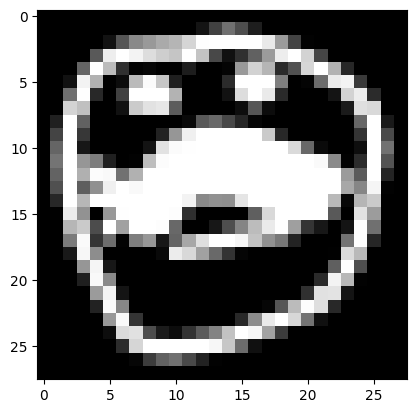

In [25]:

idx = torch.randint(0, 100, (1,))
img, label = test_dataset[idx]['image'], test_dataset[idx]['label']
img = img[0].squeeze(dim=0)
plt.imshow(img, cmap='gray')

## DataLoader

In [ ]:
from cnn import CNN # type: ignore

params = {
    'n_filters': 30,
    'hidden_dim': 100,
    'n_layers': 2,
    'n_classes': n_classes
}
model = CNN(**params)
n_params = sum([p.numel() for p in model.parameters()])
print(f'Number of params {n_params}')

Number of params 197385


In [27]:
# hyperparameters
lr = 0.001
batch_size = 128
n_epochs = 5

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

trainLoader, testLoader = DataLoader(train_dataset, batch_size=batch_size), DataLoader(test_dataset, batch_size=batch_size)

In [28]:
def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm(trainLoader):
            data, labels = batch['image'], batch['label']
            out = model(data)
            preds = out.argmax(dim=1)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds == labels).sum().item()

        train_loss /= len(trainLoader)
        train_acc /= len(trainLoader.dataset)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for batch in tqdm(testLoader, disable=True):
                data, labels = batch['image'], batch['label']
                out = model(data)
                loss = criterion(out, labels)
                preds = out.argmax(dim=1)
                test_loss += loss.item()
                test_acc += (preds == labels).sum().item()

        test_loss /= len(testLoader)
        test_acc /= len(testLoader.dataset)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print(f'epoch {epoch} | train loss {train_loss:.3f} train acc {train_acc:.2f} | test loss {test_loss:.3f} test acc {test_acc:.2f}')
    return train_losses, train_accs, test_losses, test_accs


In [29]:
train_losses, train_accs, test_losses, test_accs = train(model, trainLoader, testLoader, criterion, optimizer, n_epochs)

100%|██████████| 3516/3516 [03:10<00:00, 18.44it/s]


epoch 1 | train loss 3.631 train acc 0.23 | test loss 2.664 test acc 0.40


100%|██████████| 3516/3516 [03:07<00:00, 18.78it/s]


epoch 2 | train loss 2.940 train acc 0.34 | test loss 2.376 test acc 0.46


100%|██████████| 3516/3516 [03:07<00:00, 18.79it/s]


epoch 3 | train loss 2.794 train acc 0.36 | test loss 2.264 test acc 0.48


100%|██████████| 3516/3516 [03:13<00:00, 18.15it/s]


epoch 4 | train loss 2.719 train acc 0.38 | test loss 2.224 test acc 0.49


100%|██████████| 3516/3516 [03:04<00:00, 19.02it/s]


epoch 5 | train loss 2.660 train acc 0.39 | test loss 2.177 test acc 0.50


In [36]:
torch.save(model.state_dict(), 'weights/cnn.pth')

In [3]:
import torch
a = [1.4160e-04, 1.0993e-06, 3.8156e-04, 4.4470e-07, 4.6611e-06, 1.7040e-03,
        5.4053e-05, 4.0597e-05, 8.0602e-04, 4.4464e-04, 9.8627e-06, 4.5305e-04,
        2.3583e-05, 1.5589e-02, 1.8062e-04, 1.3330e-05, 1.0044e-04, 1.7876e-04,
        3.4307e-05, 1.2564e-05, 3.2702e-04, 5.9419e-05, 1.2810e-04, 2.0091e-04,
        1.4831e-03, 3.2953e-06, 5.1076e-08, 6.2568e-04, 2.0991e-04, 1.7717e-08,
        1.0832e-05, 5.4618e-03, 3.6210e-05, 5.0506e-04, 2.4797e-03, 1.0714e-05,
        1.5980e-02, 4.2009e-03, 3.0258e-04, 1.2552e-03, 4.0938e-04, 4.8275e-03,
        6.1358e-04, 5.8563e-06, 1.7474e-05, 1.4874e-05, 1.0425e-07, 1.5057e-08,
        5.5371e-03, 1.7427e-06, 3.3327e-05, 3.9865e-05, 7.4346e-07, 1.8273e-05,
        1.9072e-06, 3.6212e-04, 1.6305e-04, 1.2576e-05, 6.2315e-05, 2.3110e-05,
        3.3991e-03, 1.3029e-06, 4.5923e-05, 1.5548e-06, 2.8221e-05, 7.0026e-06,
        8.8565e-05, 9.7293e-06, 5.6768e-06, 1.8795e-03, 6.4050e-06, 1.1158e-02,
        3.2859e-05, 4.0991e-03, 2.7130e-03, 4.1013e-05, 7.3307e-04, 1.2582e-04,
        6.9792e-04, 3.4672e-04, 4.1914e-07, 2.1369e-07, 9.6396e-06, 5.8999e-05,
        1.7781e-05, 1.6063e-04, 3.7847e-05, 9.4810e-05, 5.3846e-03, 4.9201e-04,
        3.6410e-03, 7.8850e-05, 6.6762e-04, 1.4624e-02, 1.8220e-04, 8.6117e-06,
        3.5524e-06, 7.3061e-04, 1.3101e-05, 3.5656e-05, 4.4908e-05, 1.0386e-01,
        2.1363e-02, 1.6233e-05, 5.9248e-05, 1.2204e-03, 3.8073e-03, 4.3134e-03,
        1.0788e-02, 1.7312e-05, 1.8864e-02, 9.9052e-07, 3.1590e-04, 2.2367e-05,
        1.6137e-04, 1.6433e-07, 3.2531e-04, 1.6409e-04, 1.3055e-04, 1.2559e-04,
        4.0500e-04, 1.9794e-05, 4.2960e-03, 2.1819e-03, 3.0792e-04, 6.2972e-04,
        3.6497e-03, 2.0894e-02, 1.5320e-05, 8.3384e-08, 3.4648e-03, 1.6966e-04,
        2.6895e-05, 3.0674e-04, 1.7808e-07, 1.1112e-05, 1.5329e-05, 8.4447e-05,
        1.9685e-04, 5.5792e-03, 3.6118e-05, 1.3825e-05, 1.9954e-06, 1.9686e-03,
        8.7476e-02, 4.1244e-03, 5.0033e-04, 2.7143e-07, 7.5768e-06, 4.6582e-04,
        2.1237e-05, 1.3114e-04, 1.6562e-04, 4.5071e-07, 6.1988e-06, 5.1647e-04,
        1.4960e-04, 1.6540e-05, 1.9357e-06, 7.9822e-05, 7.4811e-05, 1.0876e-04,
        5.4729e-02, 2.0649e-04, 2.9603e-06, 2.3397e-04, 3.8901e-04, 1.0935e-02,
        4.4400e-03, 3.5565e-03, 1.0127e-06, 8.1955e-06, 6.9128e-03, 1.6723e-03,
        2.8853e-04, 5.1377e-06, 2.9724e-05, 2.5151e-03, 2.2190e-04, 8.7319e-05,
        7.8788e-04, 8.1244e-04, 4.5345e-05, 3.7068e-06, 3.3017e-05, 8.5178e-06,
        2.5321e-05, 2.5855e-02, 1.6579e-04, 5.8307e-08, 1.0440e-03, 2.1050e-02,
        4.1571e-02, 2.5413e-03, 1.5966e-05, 4.4657e-05, 2.2631e-03, 3.4355e-02,
        5.0772e-02, 6.0861e-03, 5.8352e-02, 1.5697e-05, 1.2926e-03, 2.0907e-04,
        2.9489e-05, 1.0877e-05, 1.0539e-05, 1.7496e-06, 3.4199e-06, 7.4703e-06,
        2.4462e-03, 9.1910e-04, 2.4606e-04, 4.4735e-05, 7.5815e-04, 1.6606e-03,
        9.2782e-04, 2.0296e-05, 1.7660e-04, 6.4110e-05, 3.5420e-07, 4.7185e-06,
        8.1304e-05, 1.4482e-02, 1.5940e-06, 2.0218e-04, 2.3296e-04, 3.0038e-06,
        1.1739e-02, 3.5614e-03, 3.3591e-03, 6.4217e-05, 3.8711e-02, 4.3382e-03,
        9.2367e-05, 1.2452e-05, 1.8852e-05, 4.9126e-06, 1.1525e-03, 6.5144e-04,
        1.7711e-05, 2.1482e-04, 1.6896e-04, 1.6237e-04, 1.8158e-03, 2.2695e-03,
        1.2130e-06, 3.3835e-05, 2.2042e-05, 6.6094e-05, 3.4534e-05, 7.6902e-09,
        2.0286e-06, 5.9616e-06, 5.5263e-04, 3.2202e-06, 8.5734e-05, 1.4856e-05,
        1.9149e-05, 5.4862e-04, 3.3832e-05, 2.0270e-04, 2.7385e-05, 3.8387e-06,
        3.8699e-05, 4.0016e-05, 1.2966e-04, 2.5215e-02, 3.6395e-04, 4.9105e-03,
        3.2486e-04, 1.8127e-05, 3.4089e-04, 1.7687e-05, 2.6164e-04, 2.9426e-04,
        3.7874e-04, 2.4356e-04, 2.0874e-05, 2.9036e-03, 4.2288e-02, 1.4097e-06,
        1.7129e-04, 1.2134e-06, 4.6084e-03, 2.3266e-06, 4.9824e-03, 8.4900e-03,
        3.3172e-04, 2.0980e-06, 1.8733e-03, 1.0437e-03, 8.4328e-03, 3.6535e-05,
        5.7822e-04, 3.9289e-03, 6.7580e-05, 1.4030e-05, 5.4362e-04, 4.2934e-06,
        1.1596e-03, 1.3683e-05, 2.2531e-05, 4.6974e-05, 1.9462e-06, 1.9062e-03,
        1.5076e-05, 5.1370e-05, 7.8128e-04, 1.0425e-06, 4.2402e-04, 2.7564e-06,
        2.3481e-07, 1.2910e-05, 1.3490e-02, 3.0848e-05, 4.9945e-04, 8.5202e-06,
        7.4669e-04, 3.7607e-05, 1.2550e-07, 2.8020e-05, 6.3092e-08, 1.2488e-05,
        8.7253e-04, 2.8686e-05, 1.3989e-07, 4.8878e-05, 4.9904e-04, 7.8285e-04,
        1.2175e-05, 4.3051e-04, 7.0007e-06, 3.7310e-04, 4.5072e-03, 3.1970e-03,
        1.5599e-04, 1.8321e-04, 1.1053e-08, 9.4170e-05, 1.8752e-04, 3.2771e-03,
        3.1096e-03, 8.5878e-10, 3.1143e-03]

In [6]:
probas = torch.tensor(a).unsqueeze(0)
probas.shape

torch.Size([1, 345])

In [13]:
for i, prob in enumerate(probas[0]):
    print(f'i {i} proba {prob}')

i 0 proba 0.0001416000013705343
i 1 proba 1.0992999932568637e-06
i 2 proba 0.0003815600066445768
i 3 proba 4.44699992385722e-07
i 4 proba 4.661099865188589e-06
i 5 proba 0.0017040000529959798
i 6 proba 5.40530018042773e-05
i 7 proba 4.059699858771637e-05
i 8 proba 0.0008060199907049537
i 9 proba 0.0004446399980224669
i 10 proba 9.862699698715005e-06
i 11 proba 0.00045304998639039695
i 12 proba 2.3582999347127043e-05
i 13 proba 0.015588999725878239
i 14 proba 0.00018062000162899494
i 15 proba 1.3330000001587905e-05
i 16 proba 0.00010043999645859003
i 17 proba 0.00017876000492833555
i 18 proba 3.430699871387333e-05
i 19 proba 1.2563999916892499e-05
i 20 proba 0.00032702001044526696
i 21 proba 5.9418998716864735e-05
i 22 proba 0.0001281000004382804
i 23 proba 0.00020090999896638095
i 24 proba 0.0014831000007689
i 25 proba 3.2953000754787354e-06
i 26 proba 5.107600031806214e-08
i 27 proba 0.0006256800261326134
i 28 proba 0.00020990999473724514
i 29 proba 1.7716999423100788e-08
i 30 proba 1